In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')


P ~ exp(-E(x,y))

In [124]:
def density(x,y):
    return np.exp(-50*x*x-15*y*y-50*x*y)
    

# Metropolis-Hastings

In [132]:

# initial point 

x0, y0 = np.array([-1,1])

Listx , Listy = [x0], [y0]

# number of sample 
N = 1000


for i in range(N):
    xn, yn = random.uniform(-1,1),random.uniform(-1,1)
    a = density(xn,yn)/density(x0,y0) 
    if a >=1:
        Listx = Listx +[xn]
        Listy = Listy +[yn]
        x0,y0 = xn, yn 
    else:
        if random.random()<a:
            Listx = Listx + [xn]
            Listy = Listy +[yn]
            x0,y0 = xn, yn
            


In [138]:
# the rate of the sample 

len(Listx)/1000.0

0.148

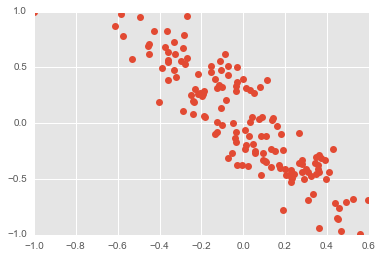

In [134]:
plt.plot(Listx, Listy,'o')

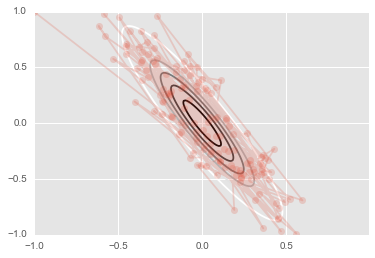

In [135]:
plt.figure()
plt.plot(Listx, Listy,'o-', alpha=0.2)
x = np.arange(-1, 1, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)
plt.contour(X,Y,density(X,Y),)

# Hamiltonian Monte Carlo

In [148]:
def density2(x1,x2,p1,p2):
    return np.exp(-50*x1*x1-50*x2*x2-15*x1*x2-p1*p1/2.0-p2*p2/2.0)

def gradE(x):
    return np.array([100*x[0]+15*x[1],15*x[0]+100*x[1]])



# initial point 
x0 = np.array([-0.5,0.5])

Listx = [x0]

# number of samples 
N = 100
T = 100
epsilon = 0.2


for i in range(N): 
    p0 = np.random.normal(0,1,2)

    for t in range(T):
        ph = p0 - epsilon* gradE(x0)/2.0
        xn = x0 + epsilon* ph
        pn = ph - epsilon* gradE(xn)/2
    

    a = density2(xn[0],xn[1],pn[0],pn[1])/density2(x0[0],x0[1],p0[0],p0[1])

    if a >=1:
        Listx = Listx +[xn]
        x0,p0 = xn, pn 
    else:
        if random.random() < a:
            Listx = Listx + [xn]
            x0,p0 = xn, pn
            



In [149]:
# the rate of sample 

len(Listx)/100.0

0.41

In [150]:
x11=[Listx[i][0] for i in range(len(Listx))]
x22=[Listx[i][1] for i in range(len(Listx))]

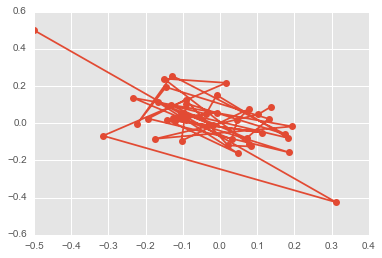

In [151]:
plt.plot(x11,x22,'o-')

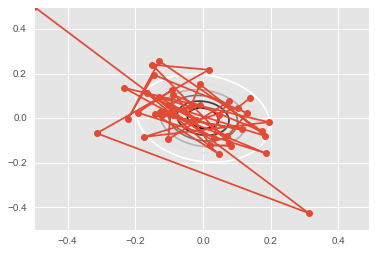

In [153]:
plt.figure()
plt.plot(x11,x22,'o-')
x1 = np.arange(-0.5, 0.5, 0.01)
x2 = np.arange(-0.5, 0.5, 0.01)
X1, X2 = np.meshgrid(x1, x2)
plt.contour(X1,X2,np.exp(-50*X1*X1-50*X2*X2-15*X1*X2))

The size of the step is quite big, but still the rate of the sample is good.   

## Elaborate version from http://people.duke.edu/~ccc14/sta-663-2016/16B_AuxiliaryVariableMCMC.html

In [3]:
import scipy.linalg as la
import seaborn as sns

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [93]:
def E(tau, u0, v0, u, v):
    """energy gap"""
    return (np.dot(np.dot(u0 , tau) , u0) + np.dot(v0 , v0)) - (np.dot(np.dot(u , tau) , u) + np.dot(v , v))

def leapfrog(A, u, v, h, N):
    """Leapfrog finite difference scheme."""
    v = v - h/2 * np.dot(A , u)
    for i in range(N-1):
        u = u + h * v
        v = v - h * np.dot(A , u)

    u = u + h * v
    v = v - h/2 * np.dot(A , u)

    return u, v

In [4]:
def E(tau, u0, v0, u, v):
    """energy gap"""
    return (np.dot(np.dot(u0 , tau) , u0) + np.dot(v0 , v0))/2 - (np.dot(np.dot(u , tau) , u) + np.dot(v , v))/2

def leapfrog(A, u, v, h, N):
    """Leapfrog finite difference scheme."""
    v = v - h * np.dot(A , u)
    for i in range(N-1):
        u = u + h * v
        v = v - h * np.dot(A , u)

    u = u + h * v
    v = v - h * np.dot(A , u)

    return u, v

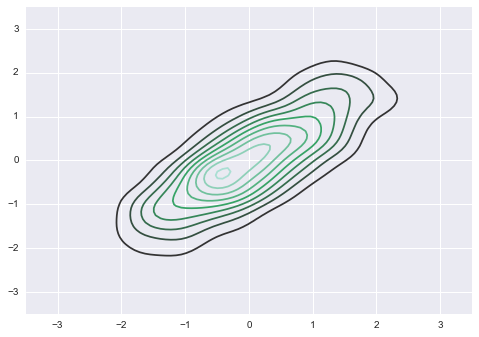

In [5]:
sigma = np.array([[1,0.8],[0.8,1]])
mu = np.zeros(2)
ys = np.random.multivariate_normal(mu, sigma, 1000)
sns.kdeplot(ys)
plt.axis([-3.5,3.5,-3.5,3.5])
pass

In [27]:
niter = 100
h = 0.1
N = 100

tau =  la.inv(sigma)


orbit = np.zeros((niter+1, 2))
u = np.array([-3,3])
orbit[0] = u
for k in range(niter):
    v0 = np.random.normal(0,1,2)
    u, v = leapfrog(tau, u, v0, h, N)

    # accept-reject
    u0 = orbit[k]
    a = np.exp(E(tau, u0, v0, u, v))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = u
    else:
        orbit[k+1] = u0

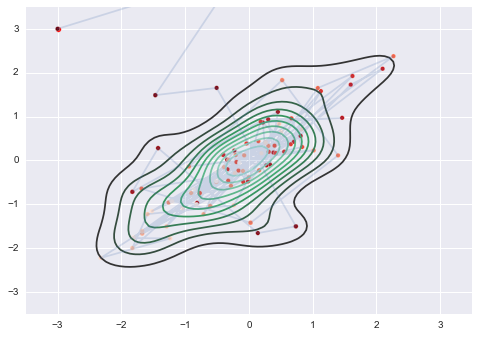

In [28]:
sns.kdeplot(orbit)
plt.plot(orbit[:,0], orbit[:,1], alpha=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=30)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds')
plt.axis([-3.5,3.5,-3.5,3.5])
pass

[-10, 10, -5, 5]

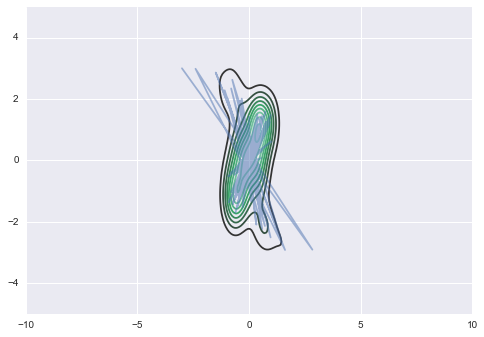

In [110]:
sns.kdeplot(orbit)
plt.plot(orbit[:,0], orbit[:,1], alpha=0.5)
plt.axis([-10,10,-5,5])



Look how the MC and HMC different when the probability density function is so narrow. 

In [82]:
niter = 100
h = 0.001
N = 100

tau =  np.array([[250.25,-249.75],[-249.75,250.25]])


orbit = np.zeros((niter+1, 2))
u = np.array([-1,1])
orbit[0] = u
for k in range(niter):
    v0 = np.random.normal(0,1,2)
    u, v = leapfrog(tau, u, v0, h, N)

    # accept-reject
    u0 = orbit[k]
    a = np.exp(E(tau, u0, v0, u, v))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = u
    else:
        orbit[k+1] = u0

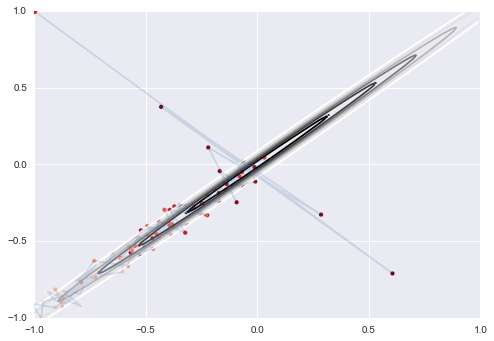

In [83]:
plt.figure()
x1 = np.arange(-1.0, 1.0, 0.01)
x2 = np.arange(-1.0, 1.0, 0.01)
X1, X2 = np.meshgrid(x1, x2)
plt.contour(X1,X2,np.exp(-(250.25*X1*X1-2*249.75*X1*X2+250.25*X2*X2)))

#sns.kdeplot(orbit)
plt.plot(orbit[:,0], orbit[:,1], alpha=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=30)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds')
plt.axis([-1,1,-1,1])
pass

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


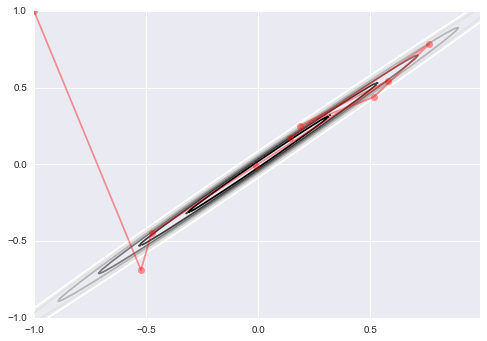

In [98]:
def density(X1,X2):
    return np.exp(-(250.25*X1*X1-2*249.75*X1*X2+250.25*X2*X2))
    
# initial point 

x0, y0 = np.array([-1,1])

Listx , Listy = [x0], [y0]

# number of sample 
N = 100


for i in range(N):
    xn, yn = random.uniform(-1,1),random.uniform(-1,1)
    a = density(xn,yn)/density(x0,y0) 
    if a >=1:
        Listx = Listx +[xn]
        Listy = Listy +[yn]
        x0,y0 = xn, yn 
    else:
        if random.random()<a:
            Listx = Listx + [xn]
            Listy = Listy +[yn]
            x0,y0 = xn, yn
            

plt.figure()
plt.plot(Listx, Listy,'o-', c='red',alpha=0.4)

y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)
plt.contour(X,Y,density(X,Y))